In [1]:
import pandas as pd
import numpy as np

import credentials
import hurdat as h
import tc_functions as fun

# Import storms since 2015 from Kim's dataset that includes shortest distance to land, and do some maneuvering to make
# things closer to the HURDAT data straight from the website for east integration with the Hurdat() class (like column names, 
# naming convention for unnamed storms, and some additional columns)
nal_15 = pd.read_table("data/DTL_NAL_2015.txt", delimiter = ' ')
nal_16 = pd.read_table("data/DTL_NAL_2016.txt", delimiter = ' ')
nal_17 = pd.read_table("data/DTL_NAL_2017.txt", delimiter = ' ')
nal_18 = pd.read_table("data/DTL_NAL_2018.txt", delimiter = ' ')
nal_19 = pd.read_table("data/DTL_NAL_2019.txt", delimiter = ' ')
enp_15 = pd.read_table("data/DTL_ENP_2015.txt", delimiter = ' ')
enp_16 = pd.read_table("data/DTL_ENP_2016.txt", delimiter = ' ')
enp_17 = pd.read_table("data/DTL_ENP_2017.txt", delimiter = ' ')
enp_18 = pd.read_table("data/DTL_ENP_2018.txt", delimiter = ' ')
enp_19 = pd.read_table("data/DTL_ENP_2019.txt", delimiter = ' ')
total = pd.concat([nal_15, nal_16, nal_17, nal_18, nal_19, enp_15, enp_16, enp_17, enp_18, enp_19], ignore_index = True)

total.columns = ['YEAR', "PART_ID", "NAME", "DATETIME", "LAT", "LON", "WIND", "PRESSURE", "CATEGORY", "DISTANCE"]

total['DATETIME'] = pd.to_datetime(total['DATETIME'], format = "%Y%m%d%H")
total['NAME'] = total['NAME'].str.upper()
name_convert = {'UNNAMED04': 'FOUR', 
                'UNNAMED11': 'ELEVEN',
                'UNNAMED08': 'EIGHT'}
total['NAME'].loc[total['NAME'].str.contains('UNNAMED')] = [name_convert[x] for x in total['NAME'].loc[total['NAME'].str.contains('UNNAMED')]]
total['ID'] = total['PART_ID'] + total['YEAR'].astype(str)
hurdat_all = h.Hurdat(data = total)
# Filter storms by minimum intensity of 50
hurdat = hurdat_all.genesis_to_lysis_filter(minimum_wind = 50)
# Add RI / RW labels to all storm observations
hurdat.identify_events(threshold = 25)
# Add 250 km from land restriction as a column
hurdat.distance_to_land_label(min_distance = 250)

In [2]:
def extract_radius(row):
    year = row["DATETIME"].year
    month = row["DATETIME"].month
    day = row["DATETIME"].day
    hour = row["DATETIME"].hour

    print(row["ID"])

    gfs_data = fun.gfs_access(year, month, day, hour, 
                                credentials.RDA_USER, credentials.RDA_PASSWORD)
    
    # Find center in GFS data using best track as a seed:
    #center_lat, center_lon = fun.vorticity_centroid(row['LAT'], row['LON'], 
    #                                                pressure = 850, search_radius = 200, 
    #                                                calc_radius = 150, dataset = gfs_data)
    
    return fun.storm_radius(row['LAT'], row['LON'], gfs_data, max_radius = 1200,
                            pressure = 850, stride = 10, h = 25)

In [8]:
from pandarallel import pandarallel
pandarallel.initialize()
rad = hurdat.storms.parallel_apply(extract_radius, axis = 1)

5
AL072017
EP062019
EP152016
AL102019
EP052016
CP012015
AL062018
AL092016
EP172018
EP022015
EP102018
AL142017
EP092017
EP132015
AL142018
AL062015
EP062019
AL072017EP152016

AL102019
CP012015
EP052016
EP172018
AL062018
AL092016
EP022015
AL142018
EP092017
EP102018
AL062015
EP132015
EP062019
AL142017
EP052016
AL102019
AL072017
CP012015
EP162016
AL092016
EP172018
AL142018
EP022015EP092017
AL062018

AL062015
EP102018
EP132015
AL142017
EP062019
CP012015
EP052016
AL102019
EP162016
AL082017
AL092016
EP172018
AL062018
AL142018
EP092017
AL072015
EP062019
EP032015
AL142017
EP102018
EP052016
AL102019
EP132015
CP012015
EP162016
AL082017
EP172018
AL092016
AL142018
AL062018
EP092017
AL072015
EP032015
AL142017
EP062019
EP102018
EP052016
EP132015
CP012015
AL102019
AL082017
EP162016
AL092016
EP172018
AL062018
AL142018
EP092017
AL112015
EP032015
AL142017
EP062019
EP102018
EP052016
EP132015
AL102019
CP012015
EP162016
AL082017
AL092016
AL062018
EP172018
EP092017
AL142018
AL112015
EP062019
EP032015
AL142017

Text(0.5, 0, 'storm radius (km)')

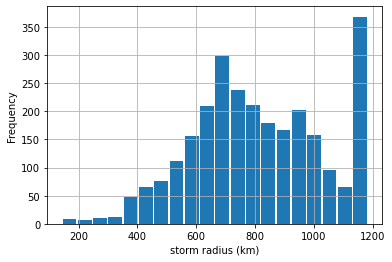

In [48]:
ax = rad.plot.hist(grid = True, bins = 20, rwidth = 0.9)
ax.set_xlabel("storm radius (km)")

In [23]:
rad_df = pd.DataFrame({'rad': np.array(rad),
                       'wind': np.array(hurdat.storms["WIND"]),
                       'RI': np.array(hurdat.storms["RI"]),
                       'near_land': np.array(hurdat.storms["NEAR_LAND"])})

<AxesSubplot:xlabel='wind', ylabel='rad'>

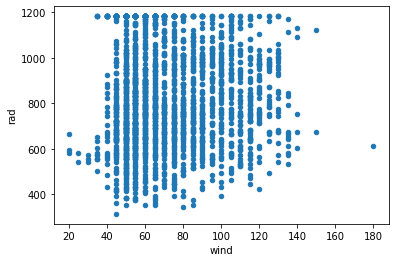

In [24]:
rad_df.loc[rad_df['near_land'] == False].plot(x = "wind", y = "rad", kind = "scatter")

In [35]:
rad_df.index[(rad_df['rad'] > 1100) & (rad_df['near_land'] == False)]

Int64Index([  51,   52,   53,   54,   59,   68,   69,   78,   79,   80,
            ...
            2512, 2513, 2514, 2515, 2516, 2518, 2587, 2588, 2589, 2590],
           dtype='int64', length=357)

In [15]:
row = hurdat.storms.iloc[2590]
row

YEAR                        2019
PART_ID                     EP10
NAME                         IVO
DATETIME     2019-08-22 18:00:00
LAT                         15.8
LON                       -113.8
WIND                          60
PRESSURE                     990
CATEGORY                      TS
DISTANCE                     444
ID                      EP102019
LEADING                    False
RI                         False
RW                         False
NEAR_LAND                  False
Name: 2590, dtype: object

EP102019


1183

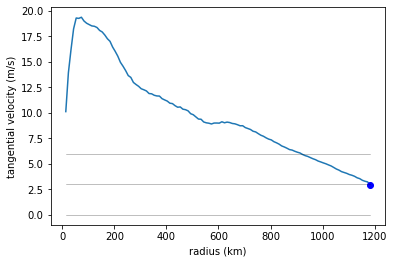

In [16]:
year = row["DATETIME"].year
month = row["DATETIME"].month
day = row["DATETIME"].day
hour = row["DATETIME"].hour

print(row["ID"])

gfs_data = fun.gfs_access(year, month, day, hour, 
                            credentials.RDA_USER, credentials.RDA_PASSWORD)

# Find center in GFS data using best track as a seed:
center_lat, center_lon = fun.vorticity_centroid(row['LAT'], row['LON'], 
                                                pressure = 850, search_radius = 200, 
                                                calc_radius = 150, dataset = gfs_data)

p_lat, p_lon = fun.pressure_min(row['LAT'], row['LON'], search_radius = 200, dataset = gfs_data)

#fun.storm_radius(center_lat, center_lon, gfs_data, max_radius = 1200,
#                 pressure = 850, stride = 10, h = 25, plot = True)
fun.storm_radius(row['LAT'], row['LON'], gfs_data, max_radius = 1200,
                 pressure = 850, stride = 10, h = 25, plot = True)

283

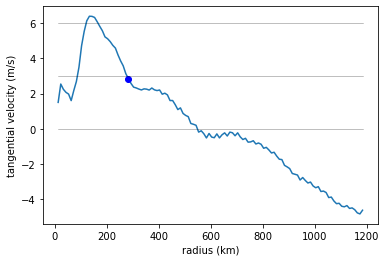

In [17]:
fun.storm_radius(row['LAT'], row['LON'], gfs_data, max_radius = 1200,
                 pressure = 200, stride = 10, h = 25, plot = True)

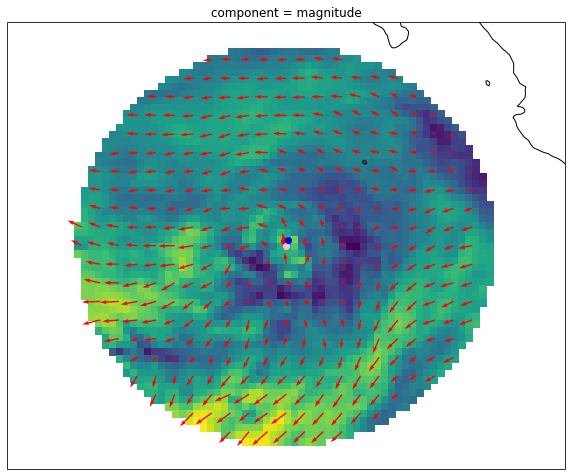

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

dataset = fun.wind_stamp(row["LAT"], row["LON"], 800, pressure = 200, dataset = gfs_data)
lat = dataset.coords['lat'].values
lon = dataset.coords['lon'].values

lon = np.where(lon > 180, lon - 360, lon)

extent = [row["LON"] - 10, row["LON"]+ 10, row["LAT"] - 8, row["LAT"] + 8]

plt.figure(figsize = (10, 10))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent(extent, ccrs.PlateCarree())
ax.coastlines('50m')
dataset[0].plot.pcolormesh(ax = ax, transform = ccrs.PlateCarree(), x = 'lon', y = 'lat', add_colorbar = False)
ax.quiver(lon, lat, dataset[1].values, dataset[2].values, color = "red", transform = ccrs.PlateCarree(), regrid_shape = 25)
ax.plot(center_lon + 360, center_lat, 'or', transform = ccrs.PlateCarree())
ax.plot(row["LON"] + 360, row["LAT"], 'o', color = 'pink', transform = ccrs.PlateCarree())
ax.plot(p_lon + 360, p_lat, 'o', color = 'blue', transform = ccrs.PlateCarree())
plt.show()